In [1]:
import mvpa2.suite as mv
from scipy.stats import zscore as sciz, pearsonr
import os.path, time
import glob
from scipy.io import loadmat 
import numpy as np
import pandas as pd
import nibabel as nb
import h5py
from mvpa2.datasets.base import Dataset
from mvpa2.misc.surfing.queryengine import SurfaceQueryEngine
from mvpa2.support.nibabel.surf import read as read_surface
from mvpa2.datasets.mri import fmri_dataset
from mvpa2.misc.neighborhood import IndexQueryEngine, Sphere
from mvpa2.datasets.base import mask_mapper
import mvpa2.misc.surfing.volume_mask_dict as volmask
from mvpa2.algorithms.searchlight_hyperalignment import SearchlightHyperalignment
from mvpa2.mappers.zscore import zscore
from mvpa2.base.hdf5 import h5save, h5load
from scipy.spatial.distance import pdist, cdist
import matplotlib.pyplot as plt


/dartfs-hpc/rc/home/1/f0040y1/.local/lib/python2.7/site-packages/mvpa2/testing/tools.py:81: DeprecationWarning: Importing from numpy.testing.decorators is deprecated since numpy 1.15.0, import from numpy.testing instead.
  from numpy.testing.decorators import skipif
/optnfs/common/miniconda3/envs/anaconda2/lib/python2.7/site-packages/_pytest/mark/structures.py:383: DeprecationWarning: The usage of `cmp` is deprecated and will be removed on or after 2021-06-01.  Please use `eq` and `order` instead.
  @attr.s(cmp=False, hash=False)


## Set Paths

In [2]:
helperfiles = '/dartfs-hpc/rc/home/1/f0040y1/CANlab/labdata/data/OLP4CBP_old_2019_lukesIsUpdating/hyperalignment/helperfiles/'
chamats = '/dartfs-hpc/rc/home/1/f0040y1/CANlab/labdata/data/OLP4CBP_old_2019_lukesIsUpdating/hyperalignment/CHA_matrices/'
logdir = '/dartfs-hpc/rc/home/1/f0040y1/CANlab/labdata/data/OLP4CBP_old_2019_lukesIsUpdating/hyperalignment/log/'
scriptsdir = '/dartfs-hpc/rc/home/1/f0040y1/CANlab/labdata/data/OLP4CBP_old_2019_lukesIsUpdating/hyperalignment/scripts/'
basedir = '/dartfs-hpc/rc/home/1/f0040y1/CANlab/labdata/data/OLP4CBP_old_2019_lukesIsUpdating/hyperalignment/'
mapdir = '/dartfs-hpc/rc/home/1/f0040y1/CANlab/labdata/data/OLP4CBP_old_2019_lukesIsUpdating/hyperalignment/transformation_matrices/'
resultsdir = '/dartfs-hpc/rc/home/1/f0040y1/CANlab/labdata/data/OLP4CBP_old_2019_lukesIsUpdating/hyperalignment/isc_results'

## Load Template to create Query Engine

In [3]:
# load nifti as a pymvpa dataset and then use that as ref_ds in the queryengine definition
# mask with mymask
#ref_ds = fmri_dataset(os.path.join(helperfiles,'olp4cbp_qe_template.nii'), mask=os.path.join(helperfiles,'brainmask.nii'))
ref_ds = fmri_dataset(os.path.join(helperfiles,'brainmask.nii'), mask=os.path.join(helperfiles,'brainmask.nii'))

len(ref_ds.fa.voxel_indices)


 * Please note: warnings are printed only once, but underlying problem might occur many times *


170804

In [4]:
# set searchlight sphere radius
sl_radius = 3.0

#create query engine
qe = IndexQueryEngine(voxel_indices=Sphere(sl_radius))
qe.train(ref_ds)

## Load Subjects for Hyperalignning

In [3]:
# number of subjects connectomes to pull in
# specify number of targets in connectome
nsubs = 202
cnx_tx = 489

In [6]:
nfiles = glob.glob(os.path.join(chamats, 'ses1_only', '*'))
mysubs = nfiles[0:nsubs]

In [138]:
mysubs[201]

'/dartfs-hpc/rc/home/1/f0040y1/CANlab/labdata/data/OLP4CBP_old_2019_lukesIsUpdating/hyperalignment/CHA_matrices/ses1_only/sub-M80399870_ses-1_task-sponpain_space-MNI152NLin2009cAsym_desc-preproc-cleaned_bold_CHA_matrix.npy'

In [139]:
max(range(202))

201

In [7]:
# import connectomes into pymvpa dataset, zscore, then add chunks and voxel indices

# ds = None
# for sub in range(len(mysubs)):
#     d = mv.Dataset(np.load(mysubs[sub]))
#     mv.zscore(d, chunks_attr=None)
#     mv.remove_invariant_features(d)
#     print(d.shape)
#     if ds is None:
#         ds = d
#     else:      
#         ds = mv.vstack((ds,d))
# ds.shape

In [7]:
# import connectomes into pymvpa dataset, zscore, then add chunks and voxel indices, append to list of datsets

dss = []
for sub in range(len(mysubs)):
    ds = mv.Dataset(np.load(mysubs[sub]))
    ds.fa['voxel_indices'] = range(ds.shape[1])
    #ds.sa['chunks'] = np.repeat(i,cnx_tx)
    mv.zscore(ds, chunks_attr=None)
    dss.append(ds)


In [8]:
print('dss sizes')
print(len(dss))
print(dss[0].shape)

dss sizes
202
(489, 170804)


In [14]:
# cs = None
# for i in range(len(mysubs)):
#     thischunk = np.repeat(i,cnx_tx)
#     if cs is None:
#         cs = thischunk
#     else:
#         cs= np.hstack((cs, thischunk))
    

# ds.sa['chunks'] = cs
# ds.fa['voxel_indices'] = range(ds.shape[1])
# ds.shape

In [15]:
# print('ds Shape: ', ds.shape)
# print('Size of voxel_indices: ', len(ds.fa.voxel_indices))
# print('Size of chunks: ', len(ds.sa.chunks))

## Run Hyperalignment

In [16]:
# create SL hyperalignment instance
hyper = SearchlightHyperalignment(
    queryengine=qe,
    compute_recon=False, # We don't need to project back from common space to subject space
    nproc=1, 
)

In [17]:
# constants 
N_JOBS=16
N_BLOCKS=128
HYPERALIGNMENT_RADIUS=5

sl_radius = HYPERALIGNMENT_RADIUS
qe = IndexQueryEngine(voxel_indices=Sphere(sl_radius))
qe.train(ref_ds)

hyper = SearchlightHyperalignment(
    queryengine=qe,
    compute_recon=False, # We don't need to project back from common space to subject space
    nproc=N_JOBS, 
    nblocks=N_BLOCKS,
    dtype ='float64'
)

maps = hyper(dss)

RuntimeError: The 'pprocess' module is required for multiprocess searchlights. Please either install python-pprocess, or reduce `nproc` to 1 (got nproc=16) or set to default None

In [18]:
toutdir = os.path.join(basedir, 'transformation_matrices', 'olp4cbp_mappers' +'_' + str(len(mysubs)) + '_'+'subs_'+ '.hdf5.gz')
t0 = time.time()
mappers = hyper(dss)

try:
    h5save(toutdir, mappers)
    print('saved hdf5 mappers')
except: 
    print('could not save hdf5 mappers')

elapsed = time.time()-t0
print('-------- time elapsed: {elapsed} --------'.format(elapsed=(time.strftime("%H:%M:%S",time.gmtime(elapsed)))))
print('saving at location: {0}'.format(toutdir))

could not save hdf5 mappers
-------- time elapsed: 01:15:33 --------
saving at location: /dartfs-hpc/rc/home/1/f0040y1/CANlab/labdata/data/OLP4CBP_old_2019_lukesIsUpdating/hyperalignment/transformation_matrices


/optnfs/common/miniconda3/envs/anaconda2/lib/python2.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


In [37]:
toutdir = os.path.join(basedir, 'transformation_matrices', 'olp4cbp_mappers' +'_' + str(len(mysubs)) + '_'+'subs'+ '.hdf5.gz')
h5save(toutdir, mappers)

## Benchmark ISCs

In [167]:
ds.shape

(489, 170804)

In [ ]:
print(len(dss))
print(dss[0].shape)
mappers = h5load(os.path.join(mapdir,'olp4cbp_mappers_202_subs.hdf5.gz'))
dss_aligned = [mapper.forward(ds) for ds, mapper in zip(dss, mappers)]
print(len(mappers))
print(dss_aligned[0].shape)


202
(489, 170804)


/optnfs/common/miniconda3/envs/anaconda2/lib/python2.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


In [140]:
def compute_average_similarity(dss, metric='correlation'):
    """
    Returns
    =======
    sim : ndarray
        A 1-D array with n_features elements, each element is the average
        pairwise correlation similarity on the corresponding feature.
    """
    n_features = dss[0].shape[1]
    sim = np.zeros((n_features, ))
    for i in range(n_features):
        data = np.array([ds.samples[:, i] for ds in dss])
        dist = pdist(data, metric)
        sim[i] = 1 - dist.mean()
    return sim

In [151]:
t0 = time.time()

a = mv.Dataset(np.random.rand(490, 170804))
b = mv.Dataset(np.random.rand(490,170804))
c = mv.Dataset(np.random.rand(490, 170804))
d = mv.Dataset(np.random.rand(490,170804))
e = mv.Dataset(np.random.rand(490, 170804))
f = mv.Dataset(np.random.rand(490,170804))
g = mv.Dataset(np.random.rand(490, 170804))
h = mv.Dataset(np.random.rand(490,170804))
i = mv.Dataset(np.random.rand(490, 170804))
j = mv.Dataset(np.random.rand(490,170804))

tds = [a,b,c,d,e,f,g,h,i,j]
s = compute_average_similarity(tds)

elapsed = time.time()-t0
print('-------- time elapsed: {elapsed} --------'.format(elapsed=(time.strftime("%H:%M:%S",time.gmtime(elapsed)))))

-------- time elapsed: 00:00:51 --------


In [168]:
z = compute_average_similarity(ds)

KeyboardInterrupt: 

In [157]:
# 5000 features = 00:00:01
# 50,000 features = 00:00:14
# 170804 features = 00:00:51

In [165]:
z

array([-0.01095351,  0.00165756, -0.01094668, ...,  0.07932772,
        0.12502357,  0.19568148])

In [87]:
n_features = dss[0].shape[1]
sim = np.zeros((n_features, ))

In [124]:
x = np.array([[1, 2, 3, 4],
              [1.5, 2, 3, 4]
              ])
y = np.array([[2, 4, 3, 2],
              [1, 2, 3, 4]
              ])

a  = np.array([[[1.0]],
              [[2.0]]
              ])
b = np.array([[[5.0]],
              [[3.0]]
              ])
c = np.array([[[5.0]],
              [[4.0]]
              ])
tds = [a,b,c]
len(tds)
z = compute_average_similarity(tds)

ValueError: A 2-dimensional array must be passed.

In [126]:
# data is the list of datasets
# align is a string indicating the type of data being used
# save is a boolean

def vertex_isc(data, align, save=True):
    all_results = []
    all_subjs = np.arange(data.shape[0])
    # loop through all vertices
    for v in np.arange(len(dss)):
        results = []
        data_v = data[:,:,v]
        for subj, ds in enumerate(data_v):
            group = np.setdiff1d(all_subjs, subj) # make groups
            group_avg = np.mean(data_v[group,:], axis=0).ravel()
            r = np.corrcoef(group_avg, ds.ravel())[0,1]
            results.append(r)
        all_results.append(np.array(results))
	#all_results.append(np.mean(np.array(results)))
    res = np.array(all_results)
    print(align)
    print(res.shape)
    if save:
        np.save(resultsdir+'{a}_vertex_isc_2d.npy'.format(a=align), res)
        print(resultsdir+'{a}_vertex_isc_2d.npy'.format(a=align))
    return res

#### 10 subs

In [13]:
isc_ha = h5load(os.path.join(resultsdir,'cha_isc_10_subs.hdf5.gz'))
isc_aa = h5load(os.path.join(resultsdir,'anatomical_isc_10_subs.hdf5.gz'))

#### 202 subs

In [3]:
isc_ha = h5load(os.path.join(resultsdir,'cha_isc_202_subs.hdf5.gz'))
isc_aa = h5load(os.path.join(resultsdir,'anatomical_isc_202_subs.hdf5.gz'))

In [4]:
print(np.mean(isc_ha))
print(np.min(isc_ha))
print(np.max(isc_ha))

0.3905997439569428
0.07009545403147843
0.5839058662708132


In [4]:
print(np.mean(isc_ha))
print(np.min(isc_ha))
print(np.max(isc_ha))

0.29028131947624364
0.04161631202581728
0.6542301999038901


In [6]:
print(np.mean(isc_aa))
print(np.min(isc_aa))
print(np.max(isc_aa))

0.12241049743630945
-0.001553231449507475
0.48876207862839816


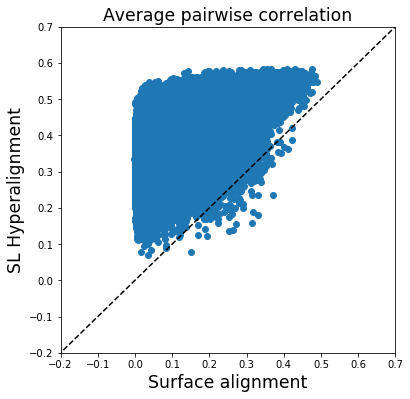

In [5]:
plt.figure(figsize=(6, 6))
plt.scatter(isc_aa, isc_ha)
plt.xlim([-.2, .7])
plt.ylim([-.2, .7])
plt.xlabel('Surface alignment', size='xx-large')
plt.ylabel('SL Hyperalignment', size='xx-large')
plt.title('Average pairwise correlation', size='xx-large')
plt.plot([-1, 1], [-1, 1], 'k--')
plt.show()

## Convert all CSV files to pickled numpy arrays

In [ ]:
import glob
import os.path
import pandas as pd
import numpy as np

openpath = '/dartfs-hpc/rc/home/1/f0040y1/CANlab/labdata/data/OLP4CBP_old_2019_lukesIsUpdating/hyperalignment/CHA_matrices'
savepath = '/dartfs-hpc/rc/home/1/f0040y1/CANlab/labdata/data/OLP4CBP_old_2019_lukesIsUpdating/hyperalignment/CHA_matrices/ndarrays'
myfiles = glob.glob(os.path.join(openpath,'*ses-1*'))

for f in myfiles:
    mysub = pd.read_csv(f, sep=',',header=None)
    npsub = mysub.to_numpy()
    fname1 = os.path.split(f)[1]
    fname = fname1[0:-4] + '.npy'
    ffull = os.path.join(savepath, fname)
    np.save(ffull, npsub, allow_pickle=True)

In [ ]:
for subj in test_subs:
    ds = Dataset(subj)
    idx = np.where(np.logical_not(np.all(ds.samples == 0, axis=0)))[0]
        ds = ds[:, idx]
        dss.append(ds)